In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb

# Next two only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022
model_scoring_dict = {}

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [26]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

X_test_comp = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

We'll first check to see if the classes are imbalanced.

In [27]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is not necessarily a huge problem, so we won't do anything about it right this second, but we may revisit the issue after we get a first rough model built.

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [29]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [31]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

## Preprocessing

In [32]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)

### Simple Imputer

In [33]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [34]:
X_train_obj = X_train_imp[obj_columns]
X_test_obj = X_test_imp[obj_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

In [35]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [36]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

log_reg_h1n1.fit(X_train_scaled, y_train_h1n1)
log_reg_ssnl.fit(X_train_scaled, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [37]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_scaled)
y_hat_ssnl = log_reg_ssnl.predict(X_test_scaled)

In [38]:
y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_scaled)

In [39]:
cf_matrix_h1n1 = confusion_matrix(y_test_h1n1, y_hat_h1n1)
cf_matrix_ssnl = confusion_matrix(y_test_ssnl, y_hat_ssnl)

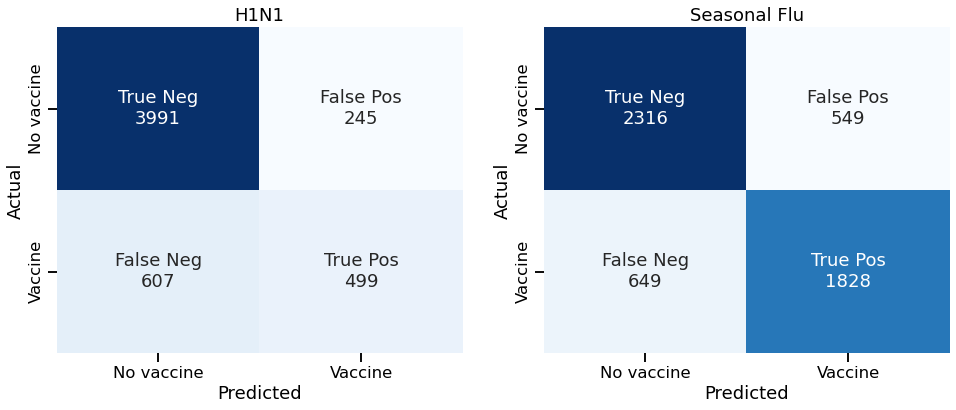

In [40]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['No vaccine', 'Vaccine']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix_h1n1.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

group_counts_2 = ['{0:0.0f}'.format(value) for value in cf_matrix_ssnl.flatten()]
labels_2 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_2)]
labels_2 = np.asarray(labels_2).reshape(2,2)

sns.set_context('talk')
fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

sns.heatmap(cf_matrix_h1n1, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax1)
ax1.set_ylabel('Actual')
ax1.set_yticklabels(ax1.get_yticklabels(), va="center")
ax1.set_xlabel('Predicted')
ax1.set_title('H1N1')

sns.heatmap(cf_matrix_ssnl, annot=labels_2, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax2)
ax2.set_ylabel('Actual')
ax2.set_yticklabels(ax2.get_yticklabels(), va="center")
ax2.set_xlabel('Predicted')
ax2.set_title('Seasonal Flu');

In [41]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl[:,1])}')

Recall for H1N1:            0.4511754068716094
Recall for seasonal flu:    0.7379895034315704

Precision for H1N1:         0.6706989247311828
Precision for seasonal flu: 0.769036600757257

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.775739423436915

F1 score for H1N1:          0.5394594594594594
F1 score for seasonal flu:  0.753193242686444

AUROC for H1N1:             0.8396438774168541
AUROC for seasonal flu:     0.8492191688842763


# Refactor into a pipeline

Now that we've got a basic and working but still fairly rough model with our cleaning steps mostly sorted out, we'll build a pipeline. We'll also code some of our graphing and scoring steps as a function so we can easily spit out several metrics for each model.

We'll also first redo our train-test split with with stratify because the H1N1-vaccinated class is slightly imbalanced. It likely won't be a drastic improvement, but we may be able to squeeze a small amount of extra juice out of any models going forward.

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)

In [364]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]

In [365]:
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()

In [366]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)
obj_columns = list(X.columns[X.dtypes == 'object'].values)
all_columns = list(X.columns.values)

### Two preprocessors, one for tree-based models, one for anything else

On closer inspection of the data, it's clear that the entire dataset is actually categorical. As such, our logistic regression would likely benefit from the whole dataset being one-hot encoded. On the other hand, tree-based models won't necessarily benefit from one-hot encoding, and a good deal of the categorical data is ordinal, which would benefit from scaling.

So one preprocessor will impute missing values and then one-hot encode every feature. The other processor will impute missing values, encode certain ordinal categories as numerical, and then min-max scale all ordinal features.

### The Common pipe

The pipelines can become somewhat complicated when attempting to run multiple imputers on different sets of columns. Because of this, we'll make a custom imputer function specifically for this dataframe before building the pipeline. This is all necessary because three of our columns have nearly half of their values missing. It seems not quite right to replace them with the mode or median (like we'll do with the rest of the columns), but we also certainly don't want to be dropping ten-thousand datapoints. So for those we'll impute their missing values by hand with 'unknown', or in the case of health_insuarance, which is binary, with 2 (which will act more or less like 'unknown'). 

We'll also ordinally encode certain columns by hand (age_group, education, and income_poverty) for similar reasons. 

In [367]:
def impute_unk(df):
    df.loc[df['employment_industry'].isna(), 'employment_industry'] = 'unknown'
    df.loc[df['employment_occupation'].isna(), 'employment_occupation'] = 'unknown'
    df.loc[df['health_insurance'].isna(), 'health_insurance'] = 2
    
    for column in df:
        if df[column].isnull().any():
            df[column]=df[column].fillna(df[column].mode()[0])

In [368]:
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [369]:
def clean(df):
    impute_unk(df)
    ord_encode(df)

In [370]:
clean(X_train)
clean(X_test)
clean(X_test_comp)

### The Linear preprocessor

In [376]:
ohe_transform = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])

In [377]:
linear_preprocessor = Pipeline(
    steps=[
        ('ohe', ohe_transform),
        ('model', LogisticRegression(max_iter=1000))
    ])

### The Tree preprocessor

In [378]:
tree_transformer = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), numeric_columns),
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
    ])

In [380]:
tree_preprocessor = Pipeline(
    steps=[
        ('tree', tree_transformer),
        ('model', RandomForestClassifier(max_depth=70, max_features='auto', min_samples_leaf=4, min_samples_split=10, n_estimators=400))
    ])

In [381]:
tree_preprocessor.fit(X_train, y_train_h1n1)
y_hat_h1n1 = tree_preprocessor.predict(X_test)
y_proba_h1n1 = tree_preprocessor.predict_proba(X_test)
y_proba_h1n1_comp = tree_preprocessor.predict_proba(X_test_comp)

tree_preprocessor.fit(X_train, y_train_ssnl)
y_hat_ssnl = tree_preprocessor.predict(X_test)
y_proba_ssnl = tree_preprocessor.predict_proba(X_test)
y_proba_ssnl_comp = tree_preprocessor.predict_proba(X_test_comp)

Recall for H1N1:    0.39118942731277534
Recall for Seasonal Flu:    0.7442424242424243

Precision for H1N1: 0.7775831873905429
Precision for Seasonal Flu: 0.7691022964509394

Accuracy for H1N1:  0.8468738300262074
Accuracy for Seasonal Flu:  0.7779857731186821

F1 score for H1N1:  0.5205158264947245
F1 score for Seasonal Flu:  0.7564681724845996

AUROC for H1N1:     0.8673921898576842
AUROC for Seasonal Flu:     0.8528471319402605


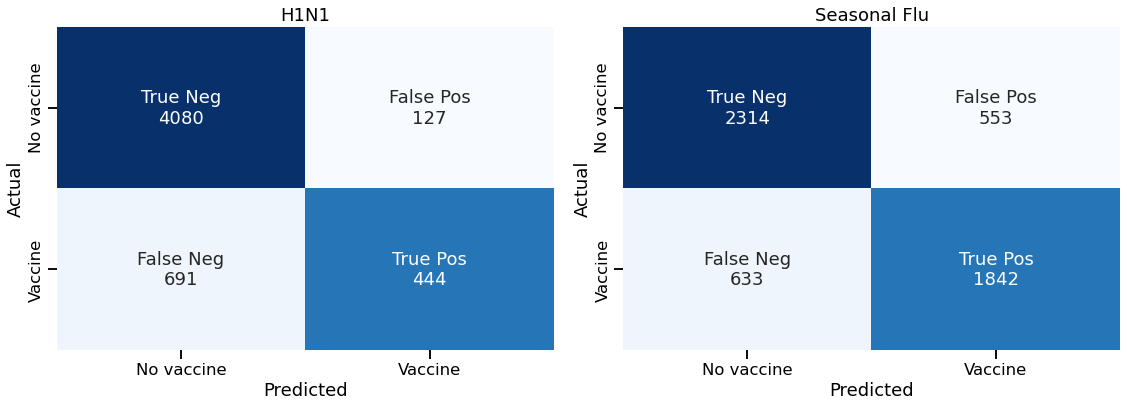

In [382]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], ['H1N1', 'Seasonal Flu'])

In [262]:
common_pipeline = Pipeline(
    steps=[
        ('imp', imputer),
        ('ohe', ohe_transform),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

In [383]:
linear_preprocessor.fit(X_train, y_train_h1n1)
y_hat_h1n1 = linear_preprocessor.predict(X_test)
y_proba_h1n1 = linear_preprocessor.predict_proba(X_test)
y_proba_h1n1_comp = linear_preprocessor.predict_proba(X_test_comp)

linear_preprocessor.fit(X_train, y_train_ssnl)
y_hat_ssnl = linear_preprocessor.predict(X_test)
y_proba_ssnl = linear_preprocessor.predict_proba(X_test)
y_proba_ssnl_comp = linear_preprocessor.predict_proba(X_test_comp)

Recall for H1N1:    0.5004405286343613
Recall for Seasonal Flu:    0.7442424242424243

Precision for H1N1: 0.7244897959183674
Precision for Seasonal Flu: 0.76814011676397

Accuracy for H1N1:  0.8534256832646949
Accuracy for Seasonal Flu:  0.7774241856982403

F1 score for H1N1:  0.5919749869723814
F1 score for Seasonal Flu:  0.7560024625487379

AUROC for H1N1:     0.8691042514625823
AUROC for Seasonal Flu:     0.8564199370756748


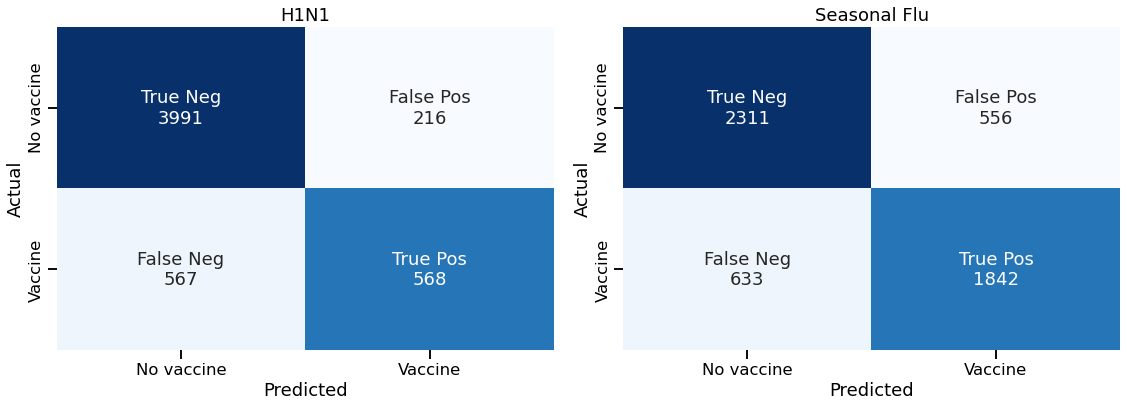

In [384]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], ['H1N1', 'Seasonal Flu'])

In [258]:
(0.8691092776984864+0.8564203598594949) / 2

0.8627648187789907

In [252]:
submission_df = pd.read_csv('data/submission_format.csv', 
                            index_col="respondent_id")

In [253]:
np.testing.assert_array_equal(X_test_comp.index.values, 
                              submission_df.index.values)

In [254]:
submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.113173,0.375069
26708,0.025997,0.028402
26709,0.244246,0.695510
26710,0.500280,0.859745
26711,0.322239,0.403610


In [255]:
submission_df.to_csv('data/my_submission.csv', index=True)

In [256]:
!head data/my_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.11317282884027721,0.37506939114042215
26708,0.02599737885236411,0.028402248436015777
26709,0.2442462051065385,0.6955101258538736
26710,0.5002803932105893,0.859745437477238
26711,0.3222389143238363,0.4036097227087465
26712,0.6852679617965983,0.9589032310334851
26713,0.19983915048877718,0.4959990653500269
26714,0.17226834641640074,0.2301630679050126
26715,0.01923289882731021,0.13394514386092657


In [190]:
imbalanced_nans = ['employment_industry', 'employment_occupation']
imbalanced_nan_num = ['health_insurance']
ord_num_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
ord_obj_columns = ['age_group', 'education', 'income_poverty']
cat_only_columns = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation', 'health_insurance']

all_columns = list(X.columns.values)

In [191]:
first_imputer = PandasSimpleImputer(strategy='constant', fill_value='unknown')
second_imputer = PandasSimpleImputer(strategy='constant', fill_value=2)
third_imputer = PandasSimpleImputer(strategy='most_frequent')

In [192]:
impute_transform_1 = PandasTransformer(transformers=[('unk', first_imputer, imbalanced_nans)])
impute_transform_2 = PandasTransformer(transformers=[('unk2', second_imputer, imbalanced_nan_num)])
impute_transform_3 = ColumnTransformer(transformers=[('imp', third_imputer, all_columns)])

In [162]:
common_pipeline = Pipeline(
    steps=[
        ('imp_unk', impute_transform_1),
        ('imp_unk_2', impute_transform_2),
        ('imp_3', impute_transform_3)
    ])

In [166]:
X_train

In [165]:
common_pipeline.fit_transform(X_train)

In [107]:
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', common_imputer, )
    ])

In [69]:
X_train.isna().sum().count()

35

In [72]:
X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)

In [73]:
X_train_imp

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18081,2,2,0,1,0,1,0,1,1,0,1,0,0,0,1,3,3,2,3,3,1,35 - 44 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,dqpwygqj,"MSA, Principle City",1,0,fcxhlnwr,xtkaffoo
4201,3,2,0,1,0,1,1,1,1,1,1,1,0,0,1,4,2,4,5,4,5,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Not Principle City",0,0,fcxhlnwr,xtkaffoo
1237,2,1,0,1,0,1,0,0,1,0,1,1,0,0,1,2,4,1,2,4,2,35 - 44 Years,College Graduate,White,Female,"> $75,000",Married,Own,Employed,fpwskwrf,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb
15265,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,5,2,2,5,2,2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,fpwskwrf,"MSA, Not Principle City",0,0,fcxhlnwr,xtkaffoo
19302,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,3,4,4,4,4,2,18 - 34 Years,12 Years,White,Female,Below Poverty,Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",1,3,cfqqtusy,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8746,2,2,0,0,0,1,0,0,0,1,1,0,0,0,1,4,2,1,5,2,1,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,fpwskwrf,"MSA, Not Principle City",2,0,fcxhlnwr,mxkfnird
6158,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,5,1,1,1,1,1,35 - 44 Years,< 12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lzgpxyit,Non-MSA,0,0,fcxhlnwr,xtkaffoo
6260,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,3,2,1,4,2,1,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,mlyzmhmf,"MSA, Principle City",1,0,wxleyezf,emcorrxb


In [485]:
common_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))])

### The Linear pipe

In [486]:
all_columns = list(X.columns.values)

In [490]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [491]:
linear_preprocessor = ColumnTransformer([('common_pipe', common_pipe, all_columns),
                                         ('ohe', categorical_transformer, all_columns)])

In [493]:
#pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)

linear_preprocessor.fit_transform(X_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### The Tree pipe

In [469]:
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [470]:
tree_pipe = Pipeline([('common_pipe', common_pipe),
                      ('ord_encoder', FunctionTransformer(ord_encode))])

In [471]:
tree_pipe.fit_transform(X_train)

KeyError: 'age_group'

In [387]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#imputer.fit(X_train)

#X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)

In [280]:
class PandasSimpleImputer(SimpleImputer):
    """
    A wrapper around 'SimpleImputer' to return data frames with columns.
    """

    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)


In [266]:
ord_encoder = FunctionTransformer(ord_obj_as_num)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit_transform(X_train)

array([[2.0, 2.0, 0.0, ..., 0.0, 'unknown', 'unknown'],
       [3.0, 2.0, 0.0, ..., 0.0, 'unknown', 'unknown'],
       [2.0, 1.0, 0.0, ..., 0.0, 'wxleyezf', 'emcorrxb'],
       ...,
       [1.0, 1.0, 0.0, ..., 0.0, 'wxleyezf', 'emcorrxb'],
       [3.0, 2.0, 0.0, ..., 0.0, 'pxcmvdjn', 'xgwztkwe'],
       [3.0, 1.0, 0.0, ..., 0.0, 'unknown', 'unknown']], dtype=object)

In [267]:
X_train.isna().sum()

h1n1_concern                     70
h1n1_knowledge                   90
behavioral_antiviral_meds        56
behavioral_avoidance            169
behavioral_face_mask             17
behavioral_wash_hands            35
behavioral_large_gatherings      74
behavioral_outside_home          68
behavioral_touch_face           108
doctor_recc_h1n1               1751
doctor_recc_seasonal           1751
chronic_med_condition           782
child_under_6_months            656
health_worker                   643
health_insurance               9790
opinion_h1n1_vacc_effective     323
opinion_h1n1_risk               321
opinion_h1n1_sick_from_vacc     323
opinion_seas_vacc_effective     381
opinion_seas_risk               416
opinion_seas_sick_from_vacc     440
age_group                         0
education                      1133
race                              0
sex                               0
income_poverty                 3556
marital_status                 1143
rent_or_own                 

In [269]:
ord_encoder.fit_transform(X_train)

ValueError: invalid literal for int() with base 10: '35 - 44 Years'

In [244]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False):
    """
    This function takes in y_data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    Note: save_fig is only supported for single models.
    
    """
    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in range(len(y_actuals)):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax1.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                print(f'Scores for {model_name}:')
            else:
                all_scores['model'] = model_scores
                print(f'Scores for this model:')
            
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

Scores for jack:
Recall:    0.4220264317180617
Precision: 0.672752808988764
Accuracy:  0.8335829277424186
F1 score:  0.5186789388197076
AUROC:     0.8365987461635684


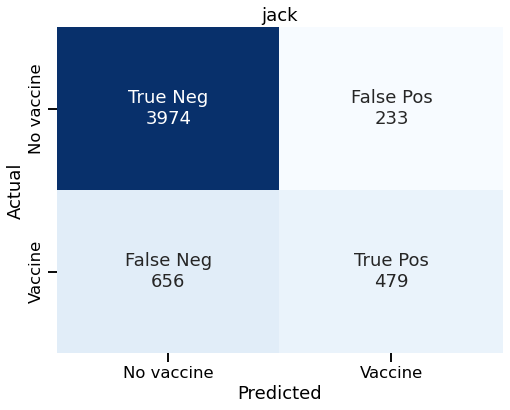

In [47]:
all_metrics(y_test_h1n1, y_hat_h1n1, y_proba_h1n1, model_name='jack')

Recall for jack:    0.4220264317180617
Recall for jill:    0.7442424242424243
Recall for bob:    0.7442424242424243
Recall for bill:    0.7442424242424243

Precision for jack: 0.672752808988764
Precision for jill: 0.7646326276463262
Precision for bob: 0.7646326276463262
Precision for bill: 0.7646326276463262

Accuracy for jack:  0.8335829277424186
Accuracy for jill:  0.7753650318232872
Accuracy for bob:  0.7753650318232872
Accuracy for bill:  0.7753650318232872

F1 score for jack:  0.5186789388197076
F1 score for jill:  0.7542997542997544
F1 score for bob:  0.7542997542997544
F1 score for bill:  0.7542997542997544

AUROC for jack:     0.8365987461635684
AUROC for jill:     0.8511540236688475
AUROC for bob:     0.8511540236688475
AUROC for bill:     0.8511540236688475


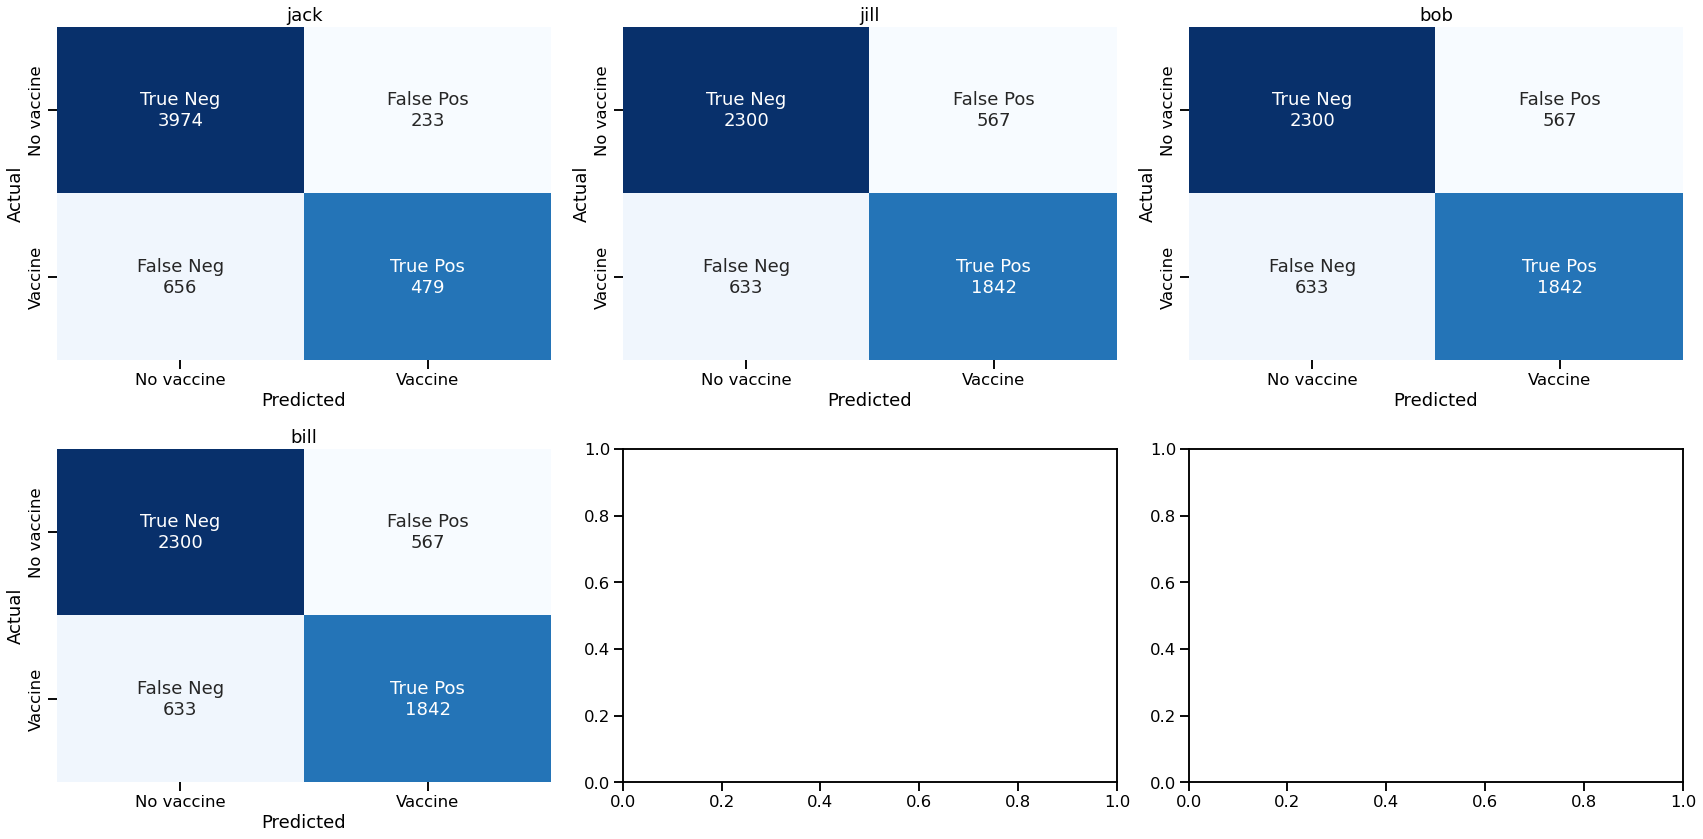

In [56]:
all_metrics([y_test_h1n1, y_test_ssnl, y_test_ssnl, y_test_ssnl], 
            [y_hat_h1n1, y_hat_ssnl, y_hat_ssnl, y_hat_ssnl], 
            y_score=[y_proba_h1n1, y_proba_ssnl, y_proba_ssnl, y_proba_ssnl], 
            model_name=['jack','jill', 'bob', 'bill'])

In [57]:
model_scoring_dict

{}

# Scratch Working Area

In [ ]:
preprocessor = Pipeline([('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                         ('ohe', OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)),
                         ('ss', StandardScaler()),
                         ('lr', LogisticRegression())])

In [ ]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

In [ ]:
preprocessor.fit_transform(X_train)
#preprocessor.transform(X_test)



In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", 
                SimpleImputer(missing_values=np.nan, strategy="most_frequent", 
                add_indicator=True)),
           ("scaler", StandardScaler())]
)


categorical_transformer = Pipeline(
    steps=[("imputer", 
                SimpleImputer(missing_values=np.nan, strategy="most_frequent", 
                add_indicator=True)),
          'ohe', OneHotEncoder(handle_unknown="ignore")]

)

preprocessor = ColumnTransformer(
    transformers=[
        ('omni', omni_transformer, numeric_columns+obj_columns),
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, obj_columns),
    ]
)

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

ss = StandardScaler()

cat_transformer = ColumnTransformer(transformers=[("ohe", ohe, obj_columns)], remainder="passthrough")

preprocessor = Pipeline(
    steps=[
        ('imputer', imputer),
        ('transformer', cat_transformer),
        ('scaler', ss)])

# Trying out a few models to diagnose any preprocessing issues

### Preprocessing for Tree-based models (though, at the end, I do run a logistic model below, just because I had it ready to go)

In [236]:
ord_num_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
ord_obj_columns = ['age_group', 'education', 'income_poverty']
cat_only_columns = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation', 'health_insurance']

In [237]:
for column in ord_obj_columns:
    print(X[column].value_counts())

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64
<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64


In [238]:
def ord_obj_as_num(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as numerical, according to a pre-defined
    list of values. This operation is in place.
    """

    age_group = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group, 'education': education, 'income_poverty': income_poverty}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [239]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [240]:
ord_obj_as_num(X_train_imp)
ord_obj_as_num(X_test_imp)

### minmax

In [241]:
X_train_num = X_train_imp.drop(cat_only_columns, axis=1)
X_test_num = X_test_imp.drop(cat_only_columns, axis=1)

In [242]:
minmax = MinMaxScaler()

X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_scaled = pd.DataFrame(minmax.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

In [243]:
X_train_obj = X_train_imp[cat_only_columns]
X_test_obj = X_test_imp[cat_only_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

In [244]:
X_train_clean = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test_clean = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [245]:
log_reg_h1n1 = LogisticRegression(max_iter=1000)
log_reg_ssnl = LogisticRegression(max_iter=1000)

log_reg_h1n1.fit(X_train_clean, y_train_h1n1)
log_reg_ssnl.fit(X_train_clean, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [246]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_clean)
y_hat_ssnl = log_reg_ssnl.predict(X_test_clean)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_clean)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_clean)

Recall for H1N1:    0.42555066079295156
Recall for Seasonal Flu:    0.7422222222222222

Precision for H1N1: 0.6764705882352942
Precision for Seasonal Flu: 0.7673350041771094

Accuracy for H1N1:  0.8347061025833021
Accuracy for Seasonal Flu:  0.7763010108573568

F1 score for H1N1:  0.5224445646295295
F1 score for Seasonal Flu:  0.7545697268432942

AUROC for H1N1:     0.8379208556328921
AUROC for Seasonal Flu:     0.8502034647134054


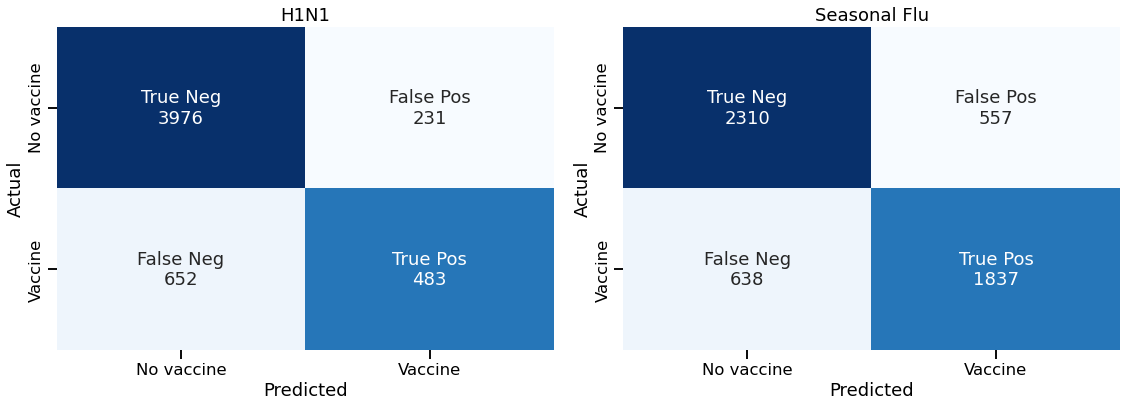

In [248]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])

# Logistic Regression, no tuning, dataset is fully OHE

### Simple Imputer

In [58]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [59]:
X_train_obj = X_train_imp
X_test_obj = X_test_imp

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [60]:
log_reg_h1n1 = LogisticRegression(max_iter=1000)
log_reg_ssnl = LogisticRegression(max_iter=1000)

log_reg_h1n1.fit(X_train_ohe, y_train_h1n1)
log_reg_ssnl.fit(X_train_ohe, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [61]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_ohe)
y_hat_ssnl = log_reg_ssnl.predict(X_test_ohe)


y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_ohe)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_ohe)

Recall for H1N1:    0.43083700440528633
Recall for Seasonal Flu:    0.7470707070707071

Precision for H1N1: 0.6735537190082644
Precision for Seasonal Flu: 0.7707378074197583

Accuracy for H1N1:  0.8347061025833021
Accuracy for Seasonal Flu:  0.7798577311868214

F1 score for H1N1:  0.5255239118753358
F1 score for Seasonal Flu:  0.7587197373820271

AUROC for H1N1:     0.8400664300845351
AUROC for Seasonal Flu:     0.8549372342187131


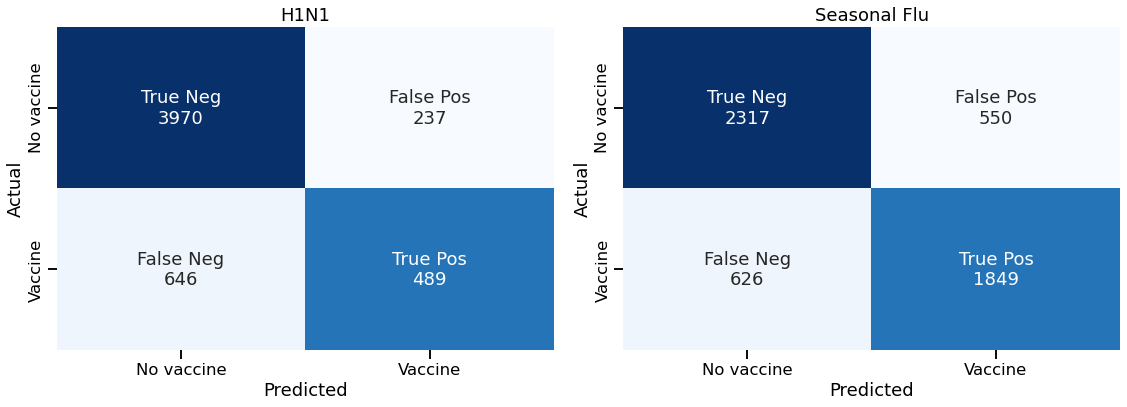

In [62]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])

### Submitting this score to the competition, to guage our low-performing models

In [63]:
submission_df = pd.read_csv('data/submission_format.csv', 
                            index_col="respondent_id")

In [69]:
np.testing.assert_array_equal(X_test_comp.index.values, 
                              submission_df.index.values)

In [71]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_test_imp_comp = pd.DataFrame(imputer.transform(X_test_comp), columns=X_test_comp.columns, index=X_test_comp.index)

In [73]:
X_test_obj_comp = X_test_imp_comp

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_test_ohe_comp = pd.DataFrame(ohe.fit_transform(X_test_obj_comp), columns=ohe.get_feature_names(), index=X_test_obj_comp.index)

X_test_ohe_comp = pd.concat([X_test_imp_comp[numeric_columns], X_test_ohe_comp], axis=1)

In [75]:
y_proba_h1n1_comp = log_reg_h1n1.predict_proba(X_test_ohe_comp)
y_proba_ssnl_comp = log_reg_ssnl.predict_proba(X_test_ohe_comp)

In [76]:
submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.063167,0.318644
26708,0.037067,0.031498
26709,0.396263,0.732449
26710,0.447803,0.846152
26711,0.206356,0.337308


In [77]:
submission_df.to_csv('data/my_submission.csv', index=True)

In [79]:
!head data/my_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.06316673777509094,0.318644409195383
26708,0.0370669600357851,0.031498393319783935
26709,0.3962627864645949,0.7324491781802666
26710,0.44780272545585964,0.8461520789716166
26711,0.20635633316102836,0.33730823058077625
26712,0.4879251639827327,0.9455146388294033
26713,0.40716808436658614,0.5698070576015274
26714,0.10365816878055854,0.18773172753498987
26715,0.05173101047121089,0.16419234936578309


### One more model - just numeric columns - competition baseline

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=random_state)

In [258]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [259]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)

In [260]:
X_train_reduced = X_train[numeric_columns]
X_test_reduced = X_test[numeric_columns]

In [261]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_reduced), columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_reduced), columns=X_test_reduced.columns, index=X_test_reduced.index)

In [262]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train_reduced)

X_train_imp = pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test_scaled), columns=X_test_scaled.columns, index=X_test_scaled.index)

In [263]:
%%time

log_reg_h1n1 = LogisticRegression(penalty="l2", C=1)
log_reg_ssnl = LogisticRegression(penalty="l2", C=1)

log_reg_h1n1.fit(X_train_imp, y_train_h1n1)
log_reg_ssnl.fit(X_train_imp, y_train_ssnl);

CPU times: user 276 ms, sys: 177 ms, total: 453 ms
Wall time: 153 ms


LogisticRegression(C=1)

### Now we'll score it and plot a confusion matrix

In [266]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_imp)
y_hat_ssnl = log_reg_ssnl.predict(X_test_imp)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_imp)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_imp)

Recall for H1N1:    0.4043803418803419
Recall for Seasonal Flu:    0.7151559454191033

Precision for H1N1: 0.6503436426116839
Precision for Seasonal Flu: 0.7458703939008895

Accuracy for H1N1:  0.8273201724529158
Accuracy for Seasonal Flu:  0.7539142273655548

F1 score for H1N1:  0.49868247694334655
F1 score for Seasonal Flu:  0.7301903221793755

AUROC for H1N1:     0.8206886901112268
AUROC for Seasonal Flu:     0.8223370964270786


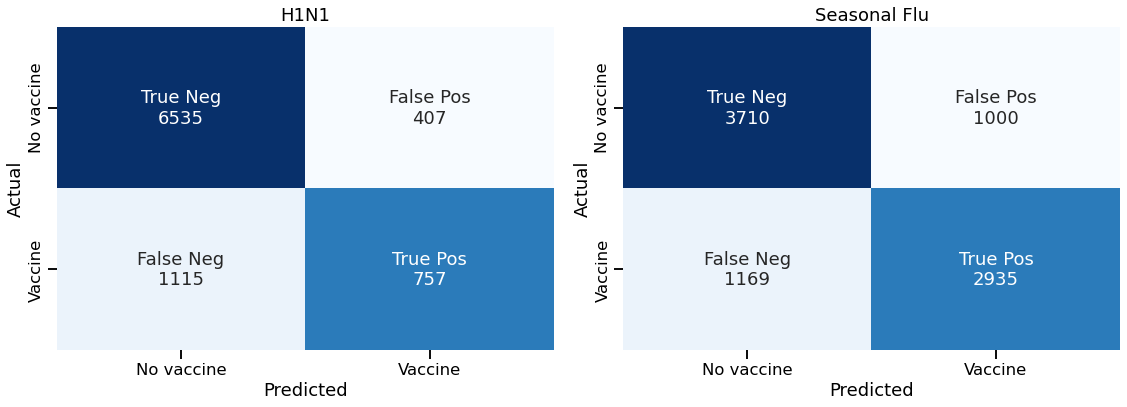

In [267]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])